<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />


<br><h2>A1: Classification Model Development</h2>



<em><strong>Game of Thrones - Characters Alive Prediction</strong></em><br>

Machine Learning - DAT-5303 - BMBAN2

<em>Martine Elisabeth Stø Johansen<em><br>
    Student ID: 10874334 
    
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [1]:
# Importing libraries
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
import gender_guesser.detector as gender # guess gender based on (given) name
import numpy as np 


# Specifying file
file = "./GOT_character_predictions.xlsx"

# Importing excel file
got = pd.read_excel(io = file,
                    header = 0,
                    sheet_name = 0)

# Formatting and printing the dimensions of the dataset
print(f"""
Size of Original Dataset
------------------------
Observations: {got.shape[0]}
Features:     {got.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 1946
Features:     25



## Functions

In [2]:
##############################################################################
# optimal_neighbors
##############################################################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.10,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed,
                                                        stratify = y_data)


    # Creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # Setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # Building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # Recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # Recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # Optionally displaying visualization
    if show_viz == True:
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # Returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


    
##############################################################################
# plot_feature_importances
##############################################################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # Declaring the number
    n_features = x_train.shape[1]
    
    # Setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')


##############################################################################
# mv_flagger
##############################################################################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df

## Missing Values and Feature Engineering 

Some new features is engineered to help better predict if a character is alive or not. As the dataset includes no known character that are older than a 100 years, the first new feature is done by creating a separate column for those that are born for more than 100 years ago. 

### Flagging Missing Values

The dataset includes missing values under several features, as most different observations have to few samples be be included. While having these features or not having could be significant.

In [3]:
# Running the mv_flagger function
got = mv_flagger(df = got)

### Feature Engineering 

#### Calculating the Year

Estimating year to be able to see based on age if people are alive or not.
While I use all people with age in the two features created for year plus age, there is no need to drop any as missing value once provide the basis.

In [4]:
# Finding the current year and oldest person
yearstd = got.loc[ : , 'dateOfBirth'].std()
yearstd = got.loc[ : , 'dateOfBirth'] < yearstd
year = got[yearstd].loc[ : , 'dateOfBirth'] + got[yearstd].loc[ : , 'age']
year = year.max()

# Checking what year the data is most likely from
print(year)

# Calculating earliest birth year with maximum lifespan
yearbefore = year - got['age'].max()

print(yearbefore)

305.0
205.0


In [5]:
# Creating different columns based on birth year, to check if characters is alive or not
got['age_birth_year'] = 0

# Adding values based on condition
for index, val in got.iterrows():
    if got.loc[index, 'dateOfBirth'] + got.loc[index, 'age'] < 305:
        got.loc[index, 'age_birth_year'] = 1
        


In [6]:
# Creating different columns based on if they have an age and birth year that is equal.
got['age_equal_year'] = 0

# Adding values based on condition
for index, val in got.iterrows():
    if got.loc[index, 'dateOfBirth'] + got.loc[index, 'age'] >= 305:
        got.loc[index, 'age_equal_year'] = 1
        

####  New Features

The following section is exploring potential features.

In [7]:
# Engineering a new feature for no parentage
got['no_parentage'] = got['m_father'] * got['m_mother']

# Creating different era column based on no allegiance and no title
got['no_allegiance_title'] = got['m_house'] * got['m_title']


In [8]:
# Engineering a new feature for characters talked about in books or appearing in the books
got['in_books'] = got['book1_A_Game_Of_Thrones'] +\
got['book2_A_Clash_Of_Kings'] +\
got['book3_A_Storm_Of_Swords'] +\
got['book4_A_Feast_For_Crows'] +\
got['book5_A_Dance_with_Dragons']


got['referenced'] = 0

# Looping to create boolean
for index, val in got.iterrows():
    
    # Adding boolean for people in the books and those just referenced
    if got.loc[ index , 'in_books'] == 0:
        got.loc[index, 'referenced'] = 1


In [9]:
# Engineering a new feature for those with only one name 
got['one_name'] = 0

# Looping to find people with one name
for index, val in got.iterrows():
    
    # Checking for people with one name
    if len(got.loc[index , 'name'].split()) == 1 :
        got.loc[index, 'one_name'] = 1
    

In [10]:
# Engineering a new feature for people not in the last book, but in more than two other
got['not_book5'] = 0

for index, val in got.iterrows():
    
    # Adding boolean for people not in book 5 and people in more than two other books 
    if got.loc[ index , 'in_books'] >= 3 and got.loc[ index , 'book5_A_Dance_with_Dragons'] == 0:
        got.loc[index, 'not_book5'] = 1

## Gender Guesser

To find gender and people with special names, I ran Gender Guesser. However, as it took to much time I decided to comment-out it here. Alternatively, I would have to run it with only part of the observations.

In [11]:
# # Splitting names

# # Placeholder list
# placeholder_lst = []

# # Looping over each name
# for index, col in got.iterrows():
    
#     # Splitting each name
#     name_split = got.loc[index, 'name'].split()
    
#     # Appending placeholder_lst with the results
#     placeholder_lst.append(name_split)
    

# # Converting placeholder_lst into a DataFrame 
# name_split = pd.DataFrame(placeholder_lst)

# # Renaming column to concatenate
# name_split.columns = ['first_name', 'second_name', 'third_name', 'fourth_name', 'fifth_name', 'sixth_name']

# # Concatenating fist name with got DataFrame
# got = pd.concat([got, name_split['first_name']],
#                    axis = 1)

In [12]:
# # Guessing gender based on names

# # Placeholder list
# placeholder_lst = []

# # Looping to guess gender
# for name in got['first_name']:
#     guess = gender.Detector().get_gender(name)
#     print(guess)
#     placeholder_lst.append(guess)

# # Converting list into a series
# got['gender_guess'] = pd.Series(placeholder_lst)

### Dummies One Hot Adding

In [13]:
# # One hot encoding variables
# one_hot_gender_guess       = pd.get_dummies(got['gender_guess'])


# # Joining codings together
# got = got.join(other = [one_hot_gender_guess])


# got['female'] = got['mostly_female'] + got['female']
# got['male'] = got['mostly_male'] + got['male'] + got['andy']

# got.drop(['male', 'gender_guess', 'first_name'], axis = 1, inplace = True)

## Dropping Columns

In [14]:
# Dropping column with missing values
got = got.dropna(axis = 1)

# Dropping columns containing string
for column in got:
    if type(got[column][0]) == str:
        got.drop([column], axis = 1, inplace = True)

In [15]:
got.columns

Index(['S.No', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings',
       'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows',
       'book5_A_Dance_with_Dragons', 'isMarried', 'isNoble',
       'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture',
       'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house',
       'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir',
       'm_isAliveSpouse', 'm_age', 'age_birth_year', 'age_equal_year',
       'no_parentage', 'no_allegiance_title', 'in_books', 'referenced',
       'one_name', 'not_book5'],
      dtype='object')

## Correlation 

In [16]:
# Checking correlations to 'isAlive'
df_corr = got.corr(method = 'pearson').round(2)

print(df_corr.loc['isAlive'].sort_values(ascending = False))

isAlive                       1.00
book4_A_Feast_For_Crows       0.27
age_equal_year                0.23
m_dateOfBirth                 0.15
m_age                         0.15
m_isAliveMother               0.14
m_father                      0.14
m_mother                      0.14
m_isAliveFather               0.14
no_parentage                  0.14
m_isAliveHeir                 0.13
m_heir                        0.13
m_isAliveSpouse               0.05
m_spouse                      0.05
m_title                       0.04
m_culture                     0.04
in_books                      0.04
m_house                       0.04
book5_A_Dance_with_Dragons    0.03
one_name                      0.03
no_allegiance_title           0.01
not_book5                     0.01
book3_A_Storm_Of_Swords       0.01
isNoble                      -0.04
isMarried                    -0.05
book2_A_Clash_Of_Kings       -0.07
S.No                         -0.13
book1_A_Game_Of_Thrones      -0.15
popularity          


## Features Options for Modeling

In [17]:
# Creating different feature options for moddeling
candidate_dict = {

 # Full model
 'logit_full'   : ['S.No', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings',
                   'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows',
                   'book5_A_Dance_with_Dragons', 'isMarried', 'isNoble',
                   'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture',
                   'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house',
                   'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir',
                   'm_isAliveSpouse', 'm_age', 'age_birth_year', 'age_equal_year',
                   'no_parentage', 'no_allegiance_title', 'in_books', 'referenced',
                   'one_name', 'not_book5'],
 

 # Significant variables only (set 1)
 'logit_best'    : ['in_books',
                    'referenced',
                    'not_book5',
                    'book1_A_Game_Of_Thrones',
                    'book2_A_Clash_Of_Kings',
                    'book4_A_Feast_For_Crows',
                    'age_birth_year',
                    'age_equal_year',
                    'popularity'],


 # Significant variables only (set 2)
 'logit_sig_smallest'  : ['popularity', 
                          'age_equal_year', 
                          'age_birth_year',
                          'book3_A_Storm_Of_Swords']
    
}


In [18]:
# train/test split with the logit_sig variables
got_data   =  got.loc[ : , candidate_dict['logit_best']]
got_target =  got.loc[ : , "isAlive"]


# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.10,
            stratify     = got_target)

## Trying Different Models To Find The Best Fitted One

### KNN

In [19]:
# Setting StandardScaler()
scaler = StandardScaler()


# Fitting the data
scaler.fit(got_data)


# Transforming the data
x_scaled     = scaler.transform(got_data)


# Converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# Train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            got_target,
            random_state = 219,
            test_size    = 0.10,
            stratify     = got_target)

#### Hyperparameter Tuning

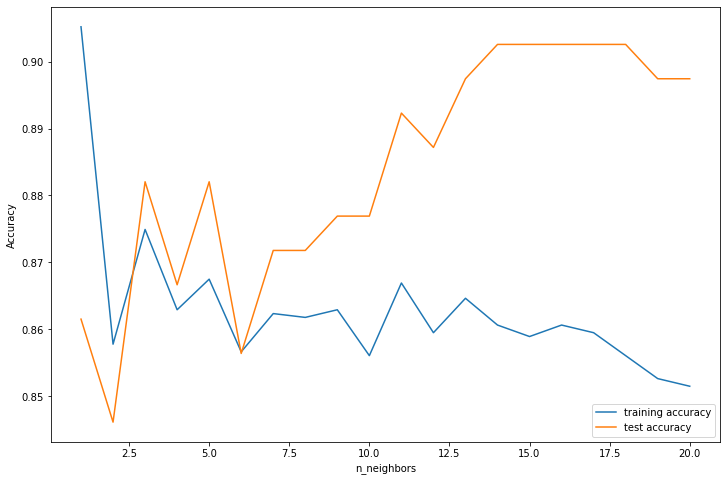

The optimal number of neighbors is: 14


In [20]:
# Determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = got_data,
                                  y_data        = got_target,
                                  response_type = 'class')

In [21]:
# # Declaring a hyperparameter space
# n_neighbors        = [opt_neighbors]
# weights            = ['uniform', 'distance']
# algorithm          = ['auto', 'ball_tree', 'ball_tree', 'kd_tree', 'brute']
# leaf_size          =  np.arange(10, 100)
# metric             = ['minkowski', 'euclidean', 'manhattan']

# # Creating a hyperparameter grid
# param_grid = {'n_neighbors' : n_neighbors,
#               'weights'         : weights,
#               'algorithm'        : algorithm,
#               'leaf_size' : leaf_size,
#               'metric'     : metric}


# # Setting the model object without hyperparameters
# tuned_knn = KNeighborsClassifier(n_neighbors = opt_neighbors)


# # RandomizedSearchCV object
# tuned_knn_cv = RandomizedSearchCV(estimator             = tuned_knn,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 1000,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))


# # Fitting to the full data
# tuned_knn_cv.fit(got_data, got_target)

# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_knn_cv.best_params_)
# print("Tuned Training AUC:", tuned_knn_cv.best_score_.round(4))

#### Running KNN

In [22]:
# Setting a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = 10, weights = 'distance', metric = 'euclidean',  
                               leaf_size = 76, algorithm = 'brute')


# Fitting the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# Predicting based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


# Scoring the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_scaled,
                                          y_score = knn_pred).round(4))


# Saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# Saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test_scaled,
                                          y_score = knn_pred).round(4)

# Unpacking the confusion matrix
knn_tn, \
knn_fp, \
knn_fn, \
knn_tp = confusion_matrix(y_true = y_test_scaled, y_pred = knn_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {knn_tn}
False Positives: {knn_fp}
False Negatives: {knn_fn}
True Positives : {knn_tp}
""")


Training ACCURACY: 0.8989
Testing  ACCURACY: 0.8821
AUC Score        : 0.8617

True Negatives : 41
False Positives: 9
False Negatives: 14
True Positives : 131



### Logistic Regression

#### Hyperparameter Tuning

In [23]:
# # Declaring a hyperparameter space
# class_weight    = ['balanced', 'dict', 'None']
# solver          = ['newton-cg', 'sag', 'lbfgs', 'saga']


# # Creating a hyperparameter grid
# param_grid = {'class_weight' : class_weight,
#               'solver'       : solver}


# # Setting the model object without hyperparameters
# lr_tuned = LogisticRegression(random_state = 219,
#                               max_iter     = 100) 


# # GridSearchCV object
# lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 12,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) 


# # Fitting to the full data
# lr_tuned_cv.fit(got_data, got_target)


# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", lr_tuned_cv.best_params_)
# print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

#### Running Logistic Regression

In [24]:
# Setting a logistic regression model
logreg = LogisticRegression(solver = 'newton-cg', class_weight = 'dict',
                            random_state = 219)


# Fitting the training data
logreg_fit = logreg.fit(x_train, y_train)


# Predicting based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# Scoring the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))

# Saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

# Unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")

# Zipping each feature name to its coefficient
logreg_model_values = zip(got_data.columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# Setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# Printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    

# Checking Coefficients 
for pair in logreg_model_lst:
    print(pair)


Training ACCURACY: 0.8384
Testing  ACCURACY: 0.8974
AUC Score        : 0.8066

True Negatives : 31
False Positives: 19
False Negatives: 1
True Positives : 144

('intercept', 1.28)
('in_books', -0.27)
('referenced', -0.21)
('not_book5', -0.71)
('book1_A_Game_Of_Thrones', -0.25)
('book2_A_Clash_Of_Kings', -0.17)
('book4_A_Feast_For_Crows', 1.7)
('age_birth_year', -4.38)
('age_equal_year', 3.47)
('popularity', -2.31)


### Classification Trees (CART Models)

#### Hyperparameter Tuning

In [25]:
# # Declaring a hyperparameter space
# criterion     = ['gini', 'entropy']
# splitter      = ['best', 'random']
# max_depth    = np.arange(2, 8)



# # Creating a hyperparameter grid
# param_grid = {'criterion'        : criterion,
#               'splitter'         : splitter,
#               'max_depth'        : max_depth}


# # Setting the model object without hyperparameters
# tuned_tree = DecisionTreeClassifier(random_state = 219)


# # RandomizedSearchCV object
# tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 1000,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))


# # Fitting to the full data
# tuned_tree_cv.fit(got_data, got_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_tree_cv.best_params_)
# print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

#### Running Classification Trees 

In [26]:
# Setting a classification tree object
tree = DecisionTreeClassifier(max_depth = 7, splitter = 'random', criterion = 'gini', random_state = 219)


# Fitting the training data
tree_fit = tree.fit(x_train, y_train)


# Predicting on new data
tree_pred = tree_fit.predict(x_test)


# Scoring the model
print('Training ACCURACY:', tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))


# Saving scoring data for future use
tree_train_score = tree_fit.score(x_train, y_train).round(4) # accuracy
tree_test_score  = tree_fit.score(x_test, y_test).round(4) # accuracy


# Saving auc score
tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tree_pred).round(4)


# Unpacking the confusion matrix
tree_tn, \
tree_fp, \
tree_fn, \
tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {tree_tn}
False Positives: {tree_fp}
False Negatives: {tree_fn}
True Positives : {tree_tp}
""")



Training ACCURACY: 0.8549
Testing  ACCURACY: 0.9128
AUC Score        : 0.8562

True Negatives : 37
False Positives: 13
False Negatives: 4
True Positives : 141



### Random Forest

#### Hyperparameter Tuning 

In [27]:
# # Declaring a hyperparameter space
# criterion  = ['gini', 'entropy']
# max_depth  = np.arange(2, 8)
# n_estimators = np.arange(10, 200, 10)


# # Creating a hyperparameter grid
# param_grid = {'n_estimators'     : n_estimators,
#               'criterion'        : criterion,
#               'max_depth'        : max_depth}


# # Setting the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 219)


# # GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 1000,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))


# # Fitting to the full dataset
# forest_cv.fit(got_data, got_target)


# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(4))

#### Running Random Forest

Building a model based on hyperparameter tuning results.

Forest Tuned Training ACCURACY: 0.8601
Forest Tuned Testing  ACCURACY: 0.9077
Forest Tuned AUC Score        : 0.8331

True Negatives : 34
False Positives: 16
False Negatives: 2
True Positives : 143



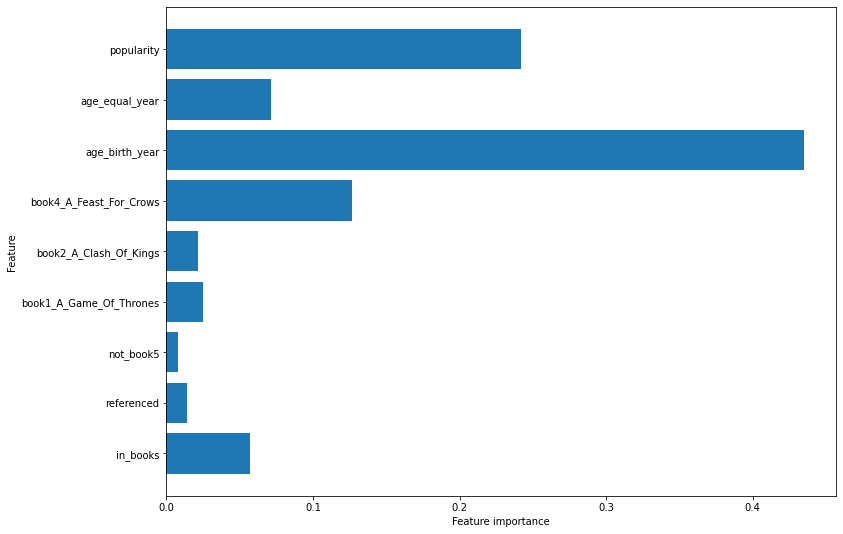

In [28]:
# Setting with best_estimator
forest_tuned = RandomForestClassifier(criterion = 'gini', max_depth = 7,
                       n_estimators=20, random_state=219)


# Fitting
forest_tuned_fit = forest_tuned.fit(x_train, y_train)


# Predicting based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# Scoring the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# Saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# Saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

# Plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = x_train,
                         export = False)

# Unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")

### Gradient Boosted Machines

#### Hyperparameter Tuning

In [29]:
# # Setting a hyperparameter space
# learning_rate        = np.arange(0.1, 2.2, 0.5)
# n_estimators    = np.arange(1, 200, 25)
# max_depth        = np.arange(2, 8, 1)
# min_samples_leaf   = np.arange(30, 51, 5)

# # Creating a hyperparameter grid
# param_grid = {'learning_rate' : learning_rate,
#               'n_estimators'     : n_estimators,
#               'max_depth'  : max_depth,
#               'min_samples_leaf'    : min_samples_leaf}


# # Setting the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# # GridSearchCV object
# full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                            param_distributions = param_grid,
#                            cv                  = 3,
#                            n_iter              = 500,
#                            random_state        = 219,
#                            scoring             = make_scorer(roc_auc_score,
#                                                  needs_threshold = False))


# # Fitting to the full model
# full_gbm_cv.fit(got_data, got_target)



# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

#### Running Gradient Boosted Machines

In [30]:
# Setting with best_estimator
gbm_tuned = GradientBoostingClassifier(learning_rate = 2.1,
                                       max_depth     = 4,
                                       n_estimators  = 1,
                                       min_samples_leaf    = 35,
                                       random_state  = 219)


# Fitting
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# Predicting based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# Scoring the results
print('Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

# Unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")

# Declaring model performance objects
gbm_train_acc = gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_test_acc  = gbm_tuned_fit.score(x_test, y_test).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test,
                              y_score = gbm_tuned_pred).round(4)



Training ACCURACY: 0.7938
Testing  ACCURACY: 0.8821
AUC Score        : 0.8683

True Negatives : 42
False Positives: 8
False Negatives: 15
True Positives : 130



## Final Output

The process to find the best combination to predict whether a character from Game of Thrones is alive or not, started by including all features and then remove one by one. Another approach that was tried was the other direction by including those with higher correlation. The final result is a combination of both, based on a holistic analysis of all model measurements. 

Looking at the final results from the different classification models, <strong>KNN</strong> stands out as the best fitted model to predict whose alive in this dataset based on Game of Thrones, based on the low train-test gap and that all scores are below 0.90. Therefore, KNN is my chosen model, even though GBM is has a higher AUC.

In [32]:
# Comparing results final model results
print(f"""
Model         AUC Score      Training Accuracy      Testing Accuracy      TN, FP, FN, TP
-----         ---------      -----------------      ----------------      --------------
*KNN           {knn_auc_score}         {knn_train_score}                {knn_test_score}               {knn_tn, knn_fp, knn_fn, knn_tp}
Logistic       {logreg_auc_score}         {logreg_train_score}                {logreg_test_score}               {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Trees          {tree_auc_score}         {tree_train_score}                {tree_test_score}               {tree_tn, tree_fp, tree_fn, tree_tp}
Random Forest  {forest_tuned_auc}         {forest_tuned_train_score}                {forest_tuned_test_score}               {tuned_rf_tn, tuned_rf_fp, tuned_rf_fn, tuned_rf_tp}
GBM            {gbm_auc}         {gbm_train_acc}                {gbm_test_acc}               {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}


* Final model
""")



Model         AUC Score      Training Accuracy      Testing Accuracy      TN, FP, FN, TP
-----         ---------      -----------------      ----------------      --------------
*KNN           0.8617         0.8989                0.8821               (41, 9, 14, 131)
Logistic       0.8066         0.8384                0.8974               (31, 19, 1, 144)
Trees          0.8562         0.8549                0.9128               (37, 13, 4, 141)
Random Forest  0.8331         0.8601                0.9077               (34, 16, 2, 143)
GBM            0.8683         0.7938                0.8821               (42, 8, 15, 130)


* Final model

